Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train' on <module '__main__' (built-in)>


Accuracy of the model: 10.23%


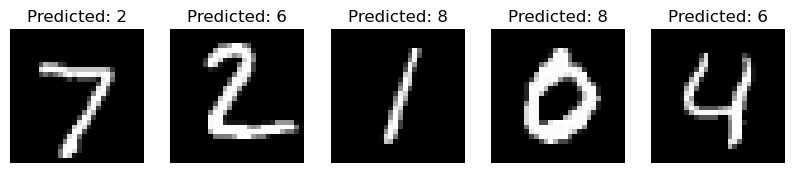

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from torch.multiprocessing import Process

# Set start method for multiprocessing
mp.set_start_method('spawn', force=True)

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders (parallelized with workers)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(rank, model, criterion, optimizer, trainloader, device, num_epochs):
    model.to(device)  # Move model to correct device
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Rank [{rank}], Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

# Testing function
def test(model, testloader, device):
    model.to(device)  # Move model to correct device
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model: {accuracy:.2f}%')
    return accuracy

# Main function
def main():
    num_epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate model, loss function, and optimizer
    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Create a process for each training task
    processes = []
    for rank in range(2):  # 2 processes (can increase)
        p = Process(target=train, args=(rank, model, criterion, optimizer, trainloader, device, num_epochs))
        p.start()
        processes.append(p)

    # Wait for all processes to finish
    for p in processes:
        p.join()

    # Test the trained model
    test(model, testloader, device)

    # Visualize some results
    def imshow(img):
        img = img / 2 + 0.5  # Unnormalize
        plt.imshow(img.numpy(), cmap='gray')
        plt.axis('off')

    # Fetch some test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

    # Show the first 5 predictions
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        imshow(images[i][0].cpu())
        plt.title(f'Predicted: {predicted[i].item()}')
    plt.show()

if __name__ == '__main__':
    main()